In [1]:
!pip install gymnasium ale-py gymnasium[atari]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: shimmy
    Found existing installation: Shimmy 1.3.0
    Uninstalling Shimmy-1.3.0:
      Successfully uninstalled Shimmy-1.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.16.9 requires shimmy>=1.2.1, but you have shimmy 0.2.1 which is incompatible.


In [2]:
!pip install gymnasium[atari,accept-rom-license]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 8.4 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446667 sha256=d66adc0266ea7c2ea494784bc690005dcbf67cbd51e57c62a84d548395f2809f
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license


In [17]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
from torch.autograd import Variable
import matplotlib.pyplot as plt

import ale_py

In [4]:
# import gym
# import numpy as np
# import random
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from collections import deque
# from torch.autograd import Variable

# Hyperparameters
GAMMA = 0.99
LR = 1e-4
BATCH_SIZE = 32
REPLAY_MEMORY_SIZE = 100000
TARGET_UPDATE_FREQ = 1000
EPSILON_START = 1.0
EPSILON_END = 0.1
EPSILON_DECAY = 10000

# Environment setup
env = gym.make("ALE/Pong-v5", frameskip=4)
n_actions = env.action_space.n
input_shape = (4, 84, 84)  # 4 stacked frames

def preprocess_frame(frame):
    """Preprocess a single frame."""
    frame = frame.mean(axis=-1)  # Grayscale
    frame = frame[34:194]  # Crop
    frame = frame[::2, ::2]  # Downsample
    return frame.astype(np.float32) / 255.0

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        c, h, w = input_shape
        self.conv = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(2304, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

def epsilon_greedy_action(state, q_net, epsilon, n_actions):
    if random.random() < epsilon:
        return random.randint(0, n_actions - 1)
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).cuda()
    with torch.no_grad():
        return q_net(state).argmax(dim=1).item()

# PGD attack function for Pong environment
def pgd_pong(model, X, y, params={}):
    """
    Simplified PGD attack for Pong environment.

    Args:
        model: The trained RL model (e.g., DDQN) to attack.
        X: Input state (e.g., image tensor).
        y: Target label or action index.
        params: Dictionary containing PGD parameters:
            - 'epsilon': Maximum perturbation (default: 0.01).
            - 'niters': Number of iterations (default: 4).
            - 'img_min': Minimum value for input (default: 0.0).
            - 'img_max': Maximum value for input (default: 1.0).
            - 'loss_func': Loss function to optimize (default: CrossEntropyLoss).

    Returns:
        X_adv: The adversarially perturbed input.
    """
    epsilon = params.get('epsilon', 0.01)
    niters = params.get('niters', 4)
    img_min = params.get('img_min', 0.0)
    img_max = params.get('img_max', 1.0)
    loss_func = params.get('loss_func', nn.CrossEntropyLoss())
    step_size = epsilon / niters

    X_adv = X.clone()
    X_adv = Variable(X_adv.data, requires_grad=True)
    y = Variable(torch.tensor(y, dtype=torch.float32)).cuda()

    for _ in range(niters):
        logits = model.forward(X_adv)
        loss = loss_func(logits, y)

        model.zero_grad()
        loss.backward()

        eta = step_size * X_adv.grad.data.sign()
        X_adv = Variable(X_adv.data + eta, requires_grad=True)

        eta = torch.clamp(X_adv.data - X.data, -epsilon, epsilon)
        X_adv.data = torch.clamp(X.data + eta, img_min, img_max)

    return X_adv.data

# Initialize networks
q_net = DQN(input_shape, n_actions).cuda()
target_net = DQN(input_shape, n_actions).cuda()
target_net.load_state_dict(q_net.state_dict())
optimizer = optim.Adam(q_net.parameters(), lr=LR)
memory = ReplayMemory(REPLAY_MEMORY_SIZE)

# Training loop
num_episodes = 1000
epsilon = EPSILON_START
epsilon_decay = (EPSILON_START - EPSILON_END) / EPSILON_DECAY
loss_fn = nn.MSELoss()

pgd_params = {
    'epsilon': 0.01,
    'niters': 4,
    'img_min': 0.0,
    'img_max': 1.0,
    'loss_func': nn.MSELoss()
}

for episode in range(num_episodes):
    state, _ = env.reset()  # Unpack observation and info
    state = preprocess_frame(state)
    state = np.stack([state] * 4, axis=0)  # Stack frames
    total_reward = 0
    
    while True:
        # Select action
        action = epsilon_greedy_action(state, q_net, epsilon, n_actions)

        # Perform action
        next_state, reward, done, _, _ = env.step(action)
        
        next_state = preprocess_frame(next_state)
        next_state = np.append(state[1:], np.expand_dims(next_state, 0), axis=0)  # Update frame stack

        memory.push((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        if len(memory) >= BATCH_SIZE:
            batch = memory.sample(BATCH_SIZE)
            states, actions, rewards, next_states, dones = zip(*batch)

            states = torch.tensor(np.array(states) , dtype=torch.float32).cuda()
            actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1).cuda()
            rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).cuda()
            next_states = torch.tensor(next_states, dtype=torch.float32).cuda()
            dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).cuda()

            q_values = q_net(states).gather(1, actions)
            next_q_values = target_net(next_states).max(1)[0].unsqueeze(1)
            
            target_q_values = rewards + (GAMMA * next_q_values * (1 - dones))

            # Introduce adversarial training
            adversarial_states = pgd_pong(q_net, states, actions.float(), params=pgd_params)
            adversarial_q_values = q_net(adversarial_states).gather(1, actions)

            # Compute loss
            target_q_values = target_q_values.squeeze(-1)
            loss = loss_fn(q_values, target_q_values) + loss_fn(adversarial_q_values, target_q_values)

            # Optimize model
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            break

    # Update target network
    if episode % TARGET_UPDATE_FREQ == 0:
        target_net.load_state_dict(q_net.state_dict())

    # Decay epsilon
    epsilon = max(EPSILON_END, epsilon - epsilon_decay)

    print(f"Episode {episode + 1}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}, Loss: {loss.item():.4f}")


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/tmp/ipykernel_23/2070350357.py:172: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  next_states = torch.tensor(next_states, dtype=torch.float32).cuda()
/tmp/ipykernel_23/2070350357.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = Variable(torch.tensor(y, dtype=torch.float32)).cuda()
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 6])). This will likely lead to incorrect results due to broadcast

Episode 1, Total Reward: -21.0, Epsilon: 1.000, Loss: 0.0015
Episode 2, Total Reward: -21.0, Epsilon: 1.000, Loss: 0.0011
Episode 3, Total Reward: -19.0, Epsilon: 1.000, Loss: 0.0608
Episode 4, Total Reward: -20.0, Epsilon: 1.000, Loss: 0.0007
Episode 5, Total Reward: -21.0, Epsilon: 1.000, Loss: 0.0607
Episode 6, Total Reward: -19.0, Epsilon: 0.999, Loss: 0.0607
Episode 7, Total Reward: -19.0, Epsilon: 0.999, Loss: 0.0659
Episode 8, Total Reward: -19.0, Epsilon: 0.999, Loss: 0.0010
Episode 9, Total Reward: -21.0, Epsilon: 0.999, Loss: 0.0609
Episode 10, Total Reward: -20.0, Epsilon: 0.999, Loss: 0.0010
Episode 11, Total Reward: -19.0, Epsilon: 0.999, Loss: 0.0009
Episode 12, Total Reward: -21.0, Epsilon: 0.999, Loss: 0.0009
Episode 13, Total Reward: -20.0, Epsilon: 0.999, Loss: 0.2458
Episode 14, Total Reward: -19.0, Epsilon: 0.999, Loss: 0.0006
Episode 15, Total Reward: -20.0, Epsilon: 0.999, Loss: 0.0010
Episode 16, Total Reward: -20.0, Epsilon: 0.999, Loss: 0.0010
Episode 17, Total

KeyboardInterrupt: 

In [19]:
loss_his = []
reward_his = []
for episode in range(num_episodes):
    state, _ = env.reset()  # Unpack observation and info
    state = preprocess_frame(state)
    state = np.stack([state] * 4, axis=0)  # Stack frames
    total_reward = 0
    
    while True:
        # Select action
        action = epsilon_greedy_action(state, q_net2, 0.3, n_actions)

        # Perform action
        next_state, reward, done, _, _ = env.step(action)
        
        next_state = preprocess_frame(next_state)
        next_state = np.append(state[1:], np.expand_dims(next_state, 0), axis=0)  # Update frame stack

        memory.push((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        if len(memory) >= BATCH_SIZE:
            batch = memory.sample(BATCH_SIZE)
            states, actions, rewards, next_states, dones = zip(*batch)

            states = torch.tensor(np.array(states) , dtype=torch.float32).cuda()
            actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1).cuda()
            rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).cuda()
            next_states = torch.tensor(next_states, dtype=torch.float32).cuda()
            dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).cuda()

            q_values = q_net2(states).gather(1, actions)
            next_q_values = target_net2(next_states).max(1)[0].unsqueeze(1)
            
            target_q_values = rewards + (GAMMA * next_q_values * (1 - dones))

            # Introduce adversarial training
            adversarial_states = pgd_pong(q_net2, states, actions.float(), params=pgd_params)
            adversarial_q_values = q_net(adversarial_states).gather(1, actions)

            # Compute loss
            target_q_values = target_q_values.squeeze(-1)
            loss = loss_fn(q_values, target_q_values) + loss_fn(adversarial_q_values, target_q_values)

            # Optimize model
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            break

    # Update target network
    if episode % TARGET_UPDATE_FREQ == 0:
        target_net2.load_state_dict(q_net2.state_dict())

    # Decay epsilon
    # epsilon = max(EPSILON_END, epsilon - epsilon_decay)
    loss_his.append(loss.item())
    reward_his.append(total_reward)

    print(f"Episode {episode + 1}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}, Loss: {loss.item():.4f}")

/tmp/ipykernel_23/626281579.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = Variable(torch.tensor(y, dtype=torch.float32)).cuda()


Episode 1, Total Reward: -21.0, Epsilon: 0.987, Loss: 0.0000
Episode 2, Total Reward: -21.0, Epsilon: 0.987, Loss: 0.0000
Episode 3, Total Reward: -21.0, Epsilon: 0.987, Loss: 0.0625
Episode 4, Total Reward: -20.0, Epsilon: 0.987, Loss: 0.0625
Episode 5, Total Reward: -20.0, Epsilon: 0.987, Loss: 0.0625
Episode 6, Total Reward: -21.0, Epsilon: 0.987, Loss: 0.1249
Episode 7, Total Reward: -21.0, Epsilon: 0.987, Loss: 0.0625
Episode 8, Total Reward: -21.0, Epsilon: 0.987, Loss: 0.0625
Episode 9, Total Reward: -21.0, Epsilon: 0.987, Loss: 0.1249
Episode 10, Total Reward: -21.0, Epsilon: 0.987, Loss: 0.0625
Episode 11, Total Reward: -20.0, Epsilon: 0.987, Loss: 0.0000
Episode 12, Total Reward: -21.0, Epsilon: 0.987, Loss: 0.0625
Episode 13, Total Reward: -21.0, Epsilon: 0.987, Loss: 0.0625
Episode 14, Total Reward: -21.0, Epsilon: 0.987, Loss: 0.0000
Episode 15, Total Reward: -21.0, Epsilon: 0.987, Loss: 0.0000
Episode 16, Total Reward: -21.0, Epsilon: 0.987, Loss: 0.0000


KeyboardInterrupt: 

In [6]:
# Save the trained model
torch.save(q_net.state_dict(), "dqn_pong_model_pgd.pth")

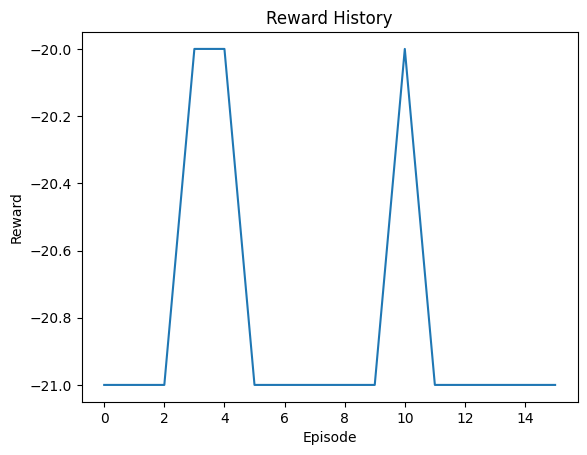

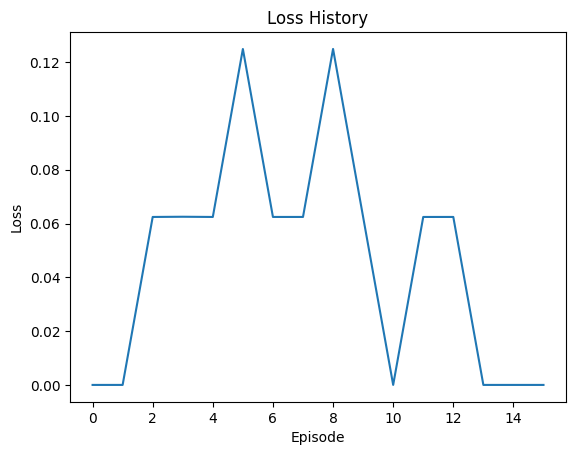

In [21]:
# Plot reward graph
plt.figure()
plt.plot(reward_his)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward History")
plt.savefig("reward_history.png")
plt.show()

# Plot loss graph
plt.figure()
plt.plot(loss_his)
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.title("Loss History")
plt.savefig("loss_history.png")
plt.show()

In [14]:
q_net2 = DQN(input_shape, n_actions).cuda()
q_net2.load_state_dict(torch.load("/kaggle/input/rl-sa-dqn1/dqn_pong_model_pgd.pth"))

target_net2 = DQN(input_shape, n_actions).cuda()
target_net2.load_state_dict(q_net2.state_dict())

/tmp/ipykernel_23/2830885354.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  q_net2.load_state_dict(torch.load("/kaggle/input/rl-sa-dqn1/dqn_pong_model_pgd.pth"))


<All keys matched successfully>

In [20]:

env = gym.make("ALE/Pong-v5", frameskip=4)

# Define the preprocess_frame function (if not already defined)
def preprocess_frame(frame):
    frame = frame.mean(axis=-1)  # Grayscale
    frame = frame[34:194]  # Crop
    frame = frame[::2, ::2]  # Downsample
    return frame.astype(np.float32) / 255.0

# PGD attack function (already defined in your code, reusing for testing if needed)
def pgd_pong(model, X, y, params={}):
    epsilon = params.get('epsilon', 0.01)
    niters = params.get('niters', 4)
    img_min = params.get('img_min', 0.0)
    img_max = params.get('img_max', 1.0)
    loss_func = params.get('loss_func', nn.CrossEntropyLoss())
    step_size = epsilon / niters

    X_adv = X.clone()
    X_adv = Variable(X_adv.data, requires_grad=True)
    y = Variable(torch.tensor(y, dtype=torch.float32)).cuda()

    for _ in range(niters):
        logits = model.forward(X_adv)
        loss = loss_func(logits, y)

        model.zero_grad()
        loss.backward()

        eta = step_size * X_adv.grad.data.sign()
        X_adv = Variable(X_adv.data + eta, requires_grad=True)

        eta = torch.clamp(X_adv.data - X.data, -epsilon, epsilon)
        X_adv.data = torch.clamp(X.data + eta, img_min, img_max)

    return X_adv.data

# Load the trained DQN model
q_net2 = DQN(input_shape, n_actions).cuda()
q_net2.load_state_dict(torch.load("/kaggle/input/rl-sa-dqn1/dqn_pong_model_pgd.pth"))
q_net2.eval() 

pgd_params = {
    'epsilon': 0.01,
    'niters': 4,
    'img_min': 0.0,
    'img_max': 1.0,
    'loss_func': nn.MSELoss()
}

# Initialize lists for tracking rewards and losses
reward_history = []
loss_history = []
num_test_episodes = 50

for episode in range(num_test_episodes):
    state, _ = env.reset()
    state = preprocess_frame(state)
    state = np.stack([state] * 4, axis=0)  # Stack initial frames
    total_reward = 0
    episode_losses = []

    while True:
        # Generate perturbed state using PGD
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).cuda()
        action = q_net2(state_tensor).argmax(dim=1).item()
        perturbed_state_tensor = pgd_pong(q_net2, state_tensor, action, pgd_params)

        # Perform action in environment using perturbed input
        perturbed_state = perturbed_state_tensor.cpu().numpy()[0]  # Convert back to numpy
        next_state, reward, done, _, _ = env.step(action)

        next_frame = preprocess_frame(next_state)
        next_state = np.append(state[1:], np.expand_dims(next_frame, 0), axis=0)
        state = next_state
        total_reward += reward

        # Compute loss
        target_q = torch.tensor(reward, dtype=torch.float32).cuda()  # Use immediate reward as a target
        predicted_q = q_net2(state_tensor).max(1)[0]
        loss = nn.MSELoss()(predicted_q, target_q)
        episode_losses.append(loss.item())

        if done:
            reward_history.append(total_reward)
            loss_history.append(np.mean(episode_losses))  # Average loss for the episode
            print(f"Episode {episode + 1}, Total Reward (Perturbed): {total_reward}, Average Loss: {np.mean(episode_losses):.4f}")
            break

# Compute average reward on perturbed inputs
average_reward_perturbed = np.mean(reward_history)
print(f"Average Reward on Perturbed Inputs: {average_reward_perturbed:.2f}")

env.close()

# Plot losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_test_episodes + 1), loss_history, marker='o', label="Loss")
plt.title("Loss per Episode on Perturbed Inputs")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()


    

/tmp/ipykernel_23/626281579.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  q_net2.load_state_dict(torch.load("/kaggle/input/rl-sa-dqn1/dqn_pong_model_pgd.pth"))


Episode 1, Total Reward (Perturbed): -21.0, Average Loss: 0.0277
Episode 2, Total Reward (Perturbed): -21.0, Average Loss: 0.0277
Episode 3, Total Reward (Perturbed): -21.0, Average Loss: 0.0277
Episode 4, Total Reward (Perturbed): -21.0, Average Loss: 0.0277
Episode 5, Total Reward (Perturbed): -21.0, Average Loss: 0.0277
Episode 6, Total Reward (Perturbed): -21.0, Average Loss: 0.0277
Episode 7, Total Reward (Perturbed): -21.0, Average Loss: 0.0277


KeyboardInterrupt: 